In [1]:
import sys
sys.path.append('../')

In [20]:
import torch
import glob
from utils.datasets.RawStreamData import RawStreamDS
from utils.functions_SX import get_ideal_basis, print_solution
import torch
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset
from models.indexer_model import ToroIndexer

import lovely_tensors as lt

lt.monkey_patch()

import os

cwd = os.getcwd()

streams_path = cwd+"/../data/lyso_12p4kev_1khz_150mm_run000026"
# streams_path = cwd+"/../data/performance_test"
mylist = glob.glob(streams_path + '/*.stream', recursive=True)
path = mylist[0]
print("Stream file to be used", path)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print("Using device ", device)

Stream file to be used /Users/lfbarba/GitHub/toro-indexer-for-serial-crystallography/notebooks/../data/lyso_12p4kev_1khz_150mm_run000026/Lyso_12p4keV_1kHz_150mm_run000026_data_000001.th6.snr4.0.mpixco1.stream
Using device  cpu


In [61]:
spot_sequence_length=80

# # performing params
lattice_size = 50000
angle_resolution = 500
num_top_solutions = 500

# # fast params
# lattice_size = 25000
# angle_resolution = 150
# num_top_solutions = 200

# super fast params
lattice_size = 20000
angle_resolution = 100
num_top_solutions = 50

im = ToroIndexer(
    lattice_size=lattice_size,
    num_iterations=5,
    error_precision=0.0012,
    filter_precision=0.00075,
    filter_min_num_spots=6
).to(device)

mds = RawStreamDS(path, spot_sequence_length, no_padding=False)

Creating DS from  /Users/lfbarba/GitHub/toro-indexer-for-serial-crystallography/notebooks/../data/lyso_12p4kev_1khz_150mm_run000026/Lyso_12p4keV_1kHz_150mm_run000026_data_000001.th6.snr4.0.mpixco1.stream


Num crystals  4 tensor[4] bool x∈[False, True] μ=0.250 σ=0.500 [True, False, False, False]
Success  tensor bool True
8 spots
error tensor(0.0010) penalization tensor(8.0207)
length of found basis vectors  tensor([79.1824, 78.3194, 38.2710])
ideal length of vectors  tensor([79.5000, 79.5000, 38.6000])


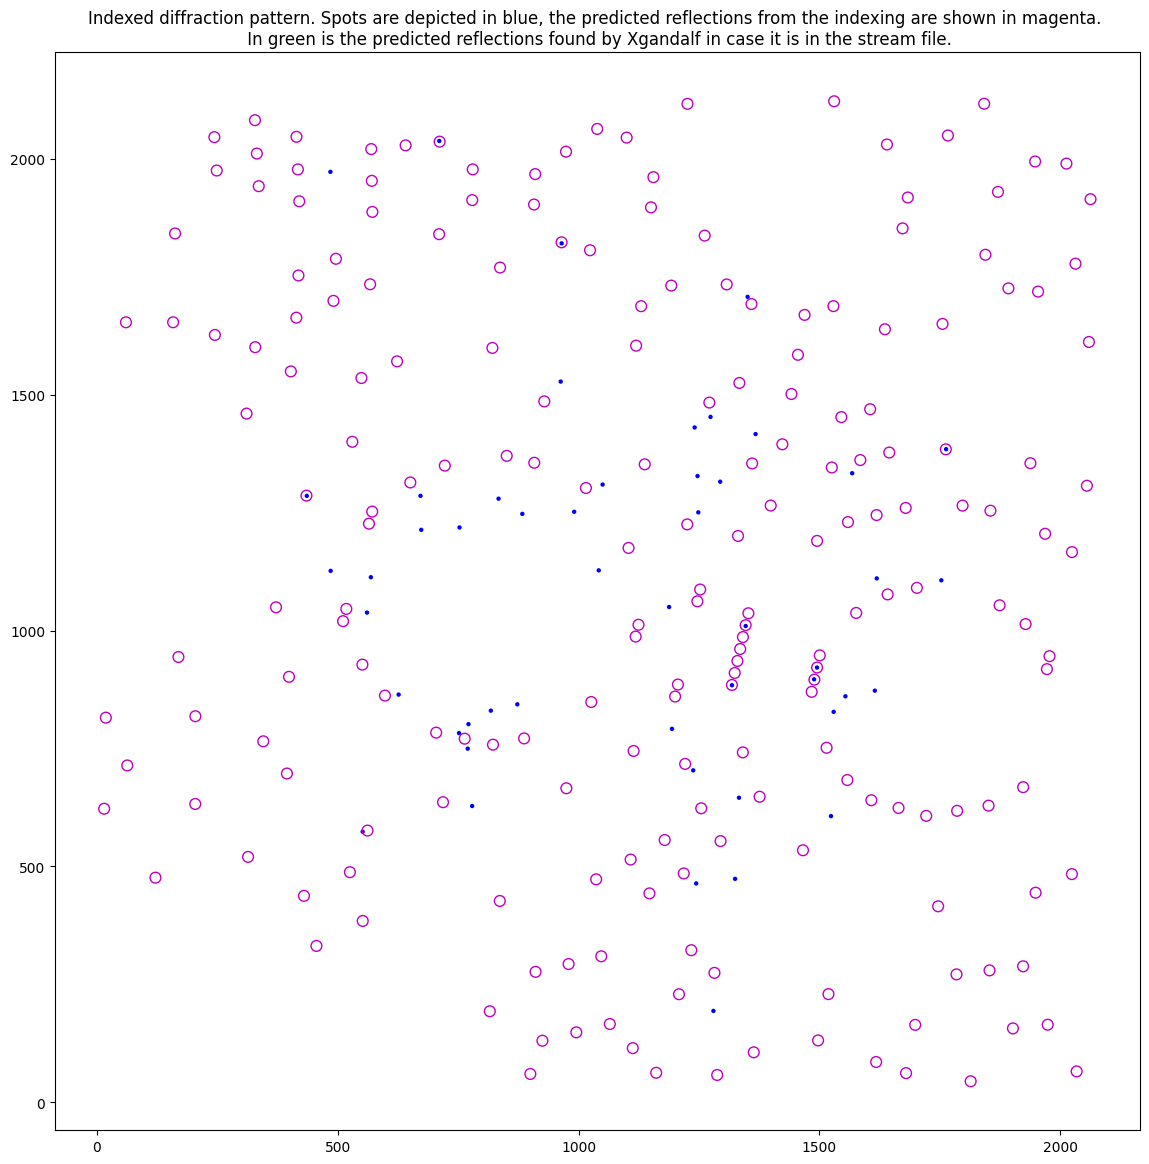

Success  tensor bool False
7 spots
error tensor(0.0008) penalization tensor(116.3605)
length of found basis vectors  tensor([82.9563, 79.5283, 39.5910])
ideal length of vectors  tensor([79.5000, 79.5000, 38.6000])


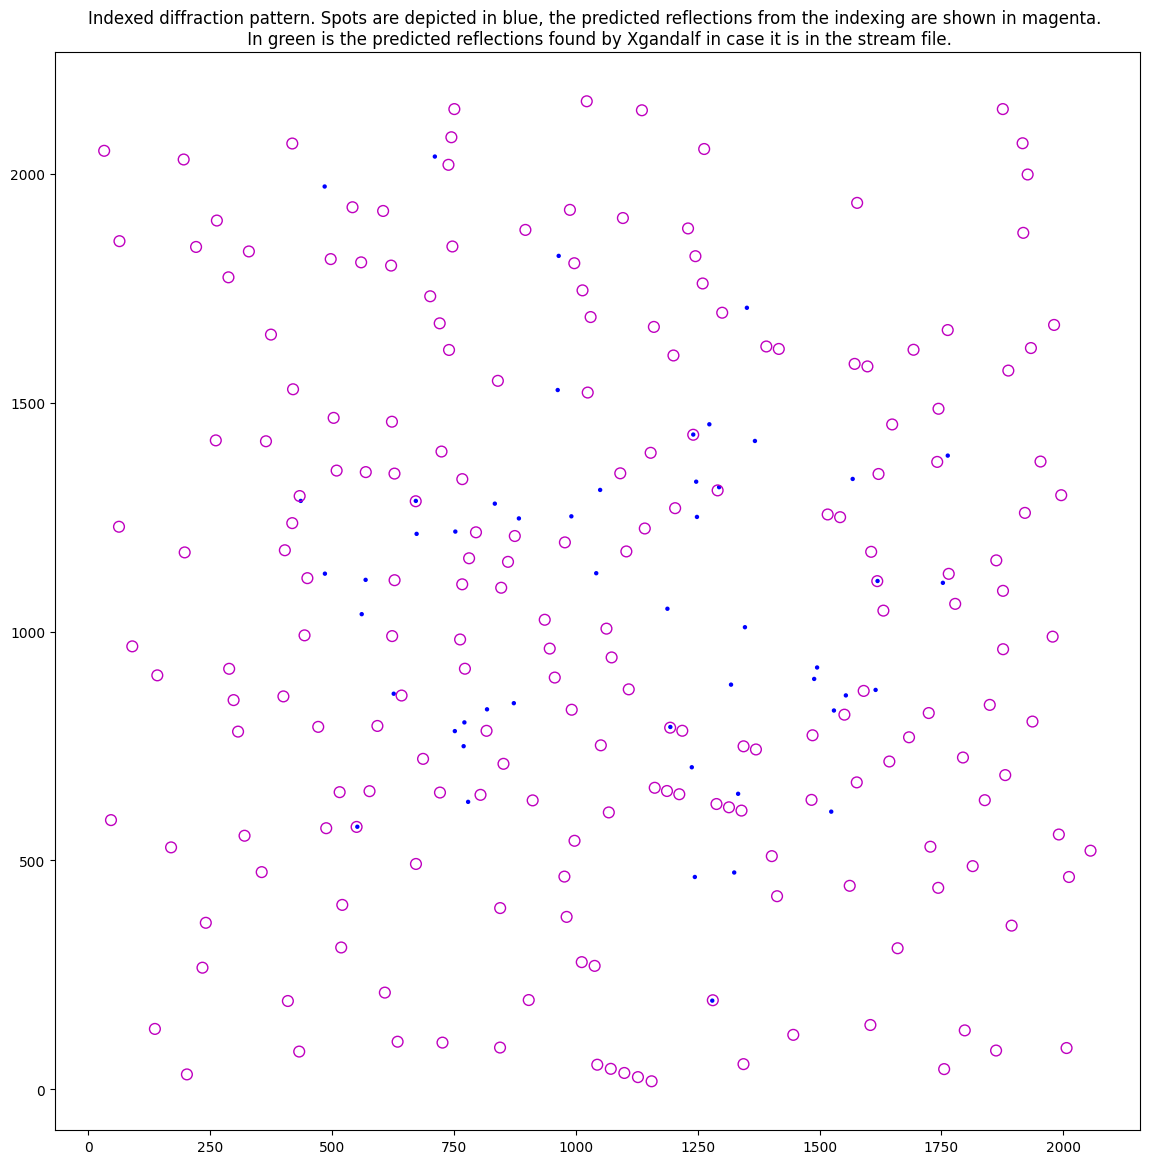

Success  tensor bool False
5 spots
error tensor(0.0012) penalization tensor(151.8893)
length of found basis vectors  tensor([77.7230, 81.3910, 37.0814])
ideal length of vectors  tensor([79.5000, 79.5000, 38.6000])


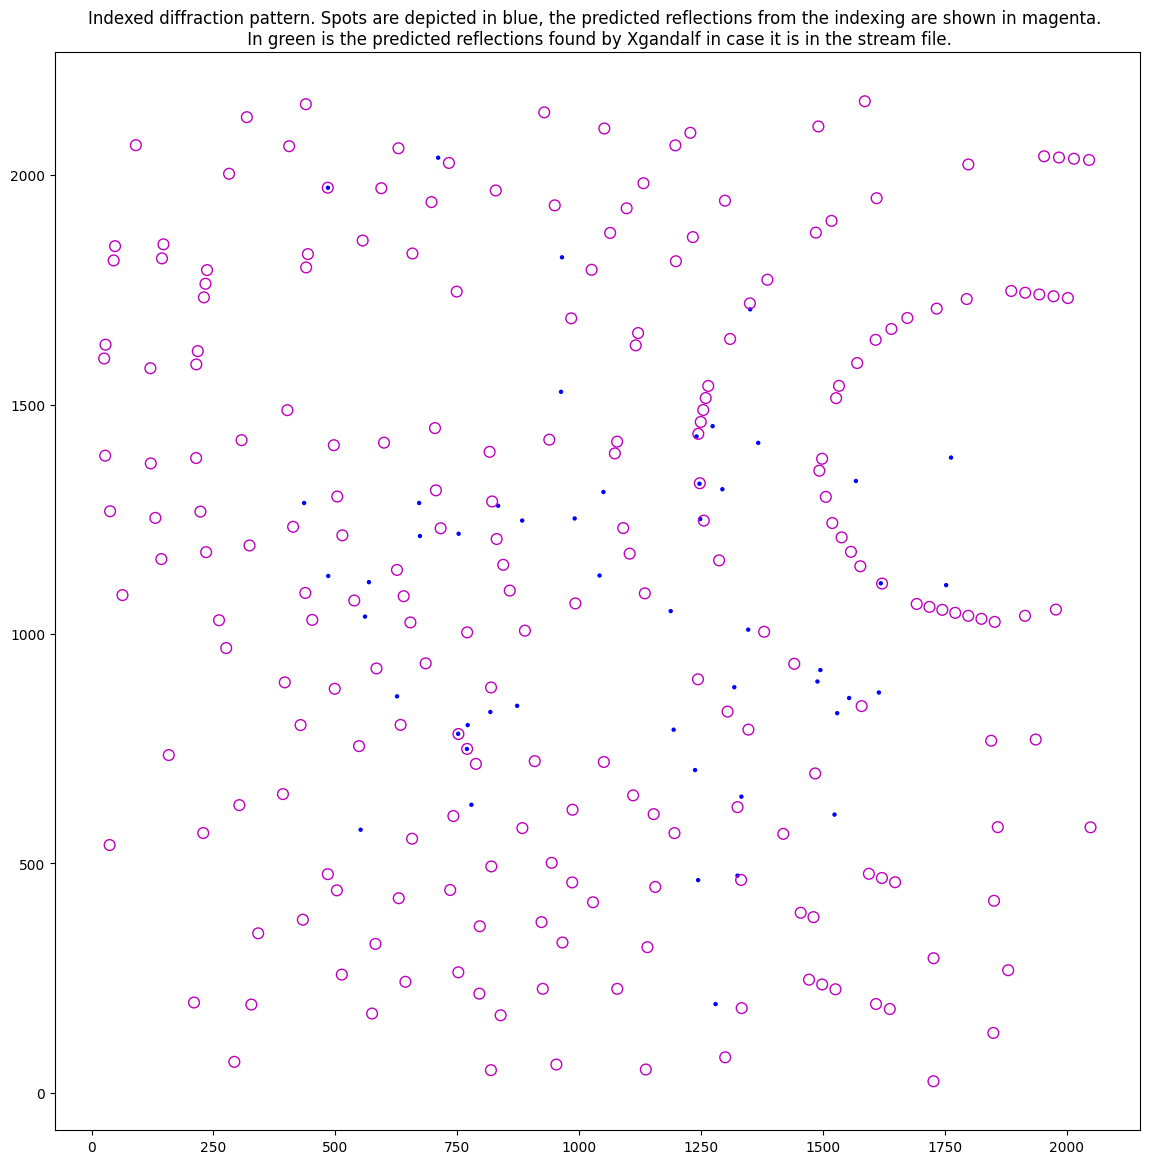

Success  tensor bool False
4 spots
error tensor(0.0011) penalization tensor(200.5439)
length of found basis vectors  tensor([83.6393, 83.5107, 39.2961])
ideal length of vectors  tensor([79.5000, 79.5000, 38.6000])


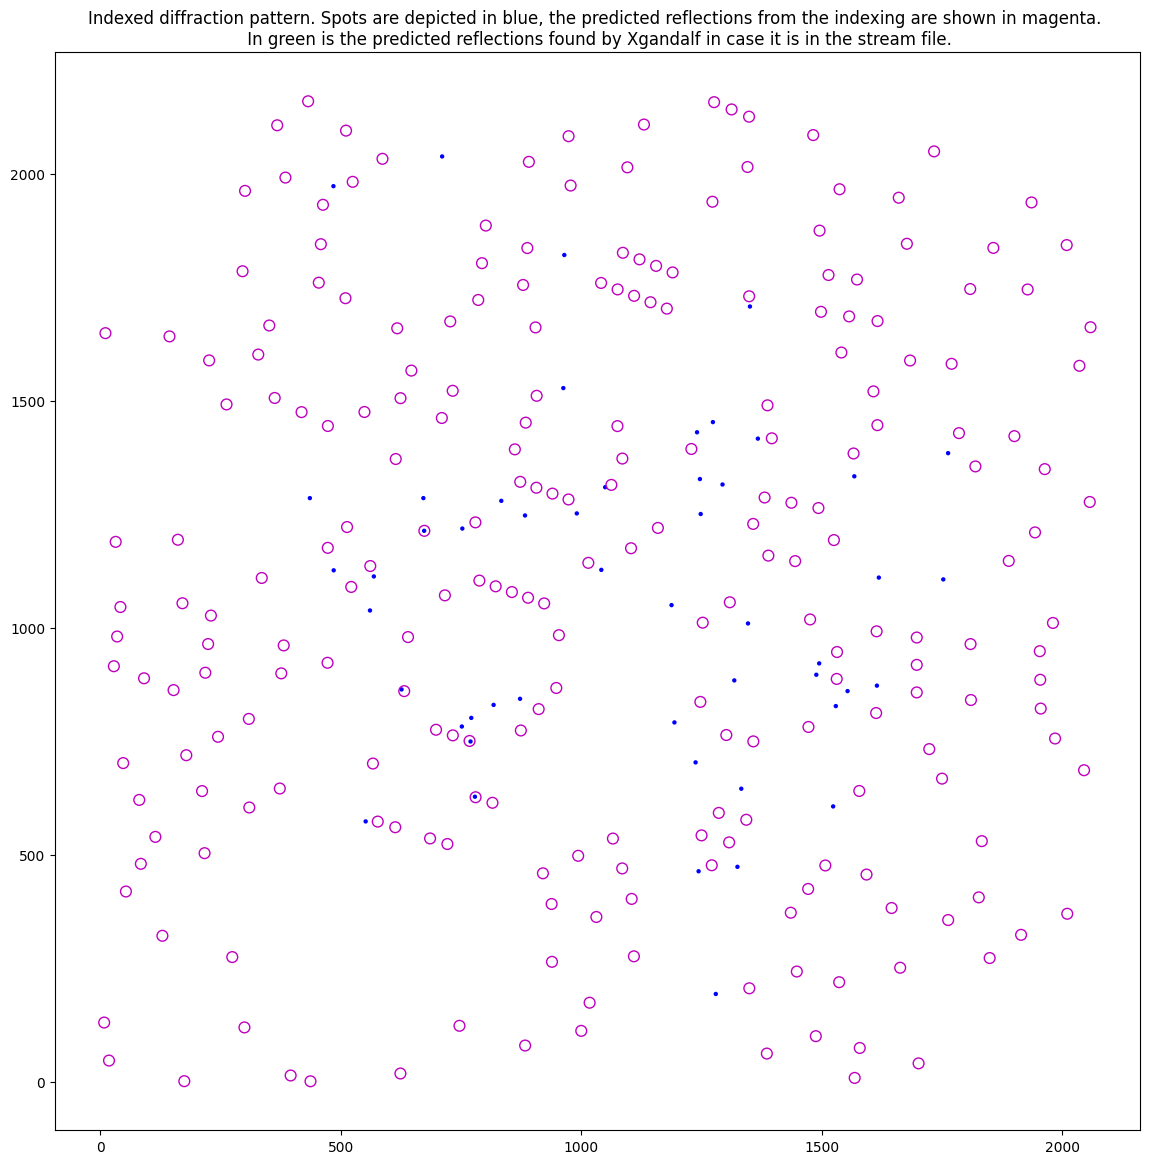

In [66]:
import random
# We load the indices produded by the stream_file_indexer.py
# indices = np.load("../solution_indices.npy")
# idx = indices[random.randint(0, len(indices) - 1)]
# idx = 6471
# idx = random.randint(0, len(mds) - 1)
cell_parameters = mds.instances[mds_idx]['initial_cell']
initial_cell = get_ideal_basis(cell_parameters)

peaks, _ = mds[mds_idx]

solution_successes, solution_triples, solution_masks, solution_errors, solution_penalization = im(
        peaks.repeat(1, 1, 1).to(device),
        initial_cell.to(device),
        min_num_spots=1,
        angle_resolution=angle_resolution,
        num_top_solutions=num_top_solutions
    )


with torch.no_grad():
    for batch, (success_crystals, matrix_crystals, peaks_indices_crystals, error_crystals, penalization_crystals) in enumerate(zip(
            solution_successes, solution_triples, solution_masks, solution_errors, solution_penalization
    )):
        print("Num crystals ", len(success_crystals), success_crystals)
        idx_crystal = 0
        for success, best_triple, solution_mask, claimed_error, penalization in zip(success_crystals, matrix_crystals, peaks_indices_crystals, error_crystals, penalization_crystals):
            print("Success ", success)
            rot_data = im.solution_sources[batch][idx_crystal] @ best_triple.T
            targets = torch.round(rot_data)
            back_peaks = targets @ torch.inverse(best_triple).T

            print(torch.sum(solution_mask).item(), "spots")

            print("error", claimed_error.p, "penalization", penalization.p)

            print("length of found basis vectors ", best_triple.norm(dim=-1).p)
            print("ideal length of vectors ", initial_cell.norm(dim=-1).p)
            
            print_solution(best_triple, mds_idx, mds, initial_cell)
            
            best_hkl = torch.round(im.solution_sources[batch][idx_crystal][solution_mask] @ best_triple.T)
#             print(best_hkl.p)
            

# Visualize results from stream_file_indexer.py

In [39]:
indices = np.load("../solution_indices.npy")
bases = np.load("../solution_matrices.npy")

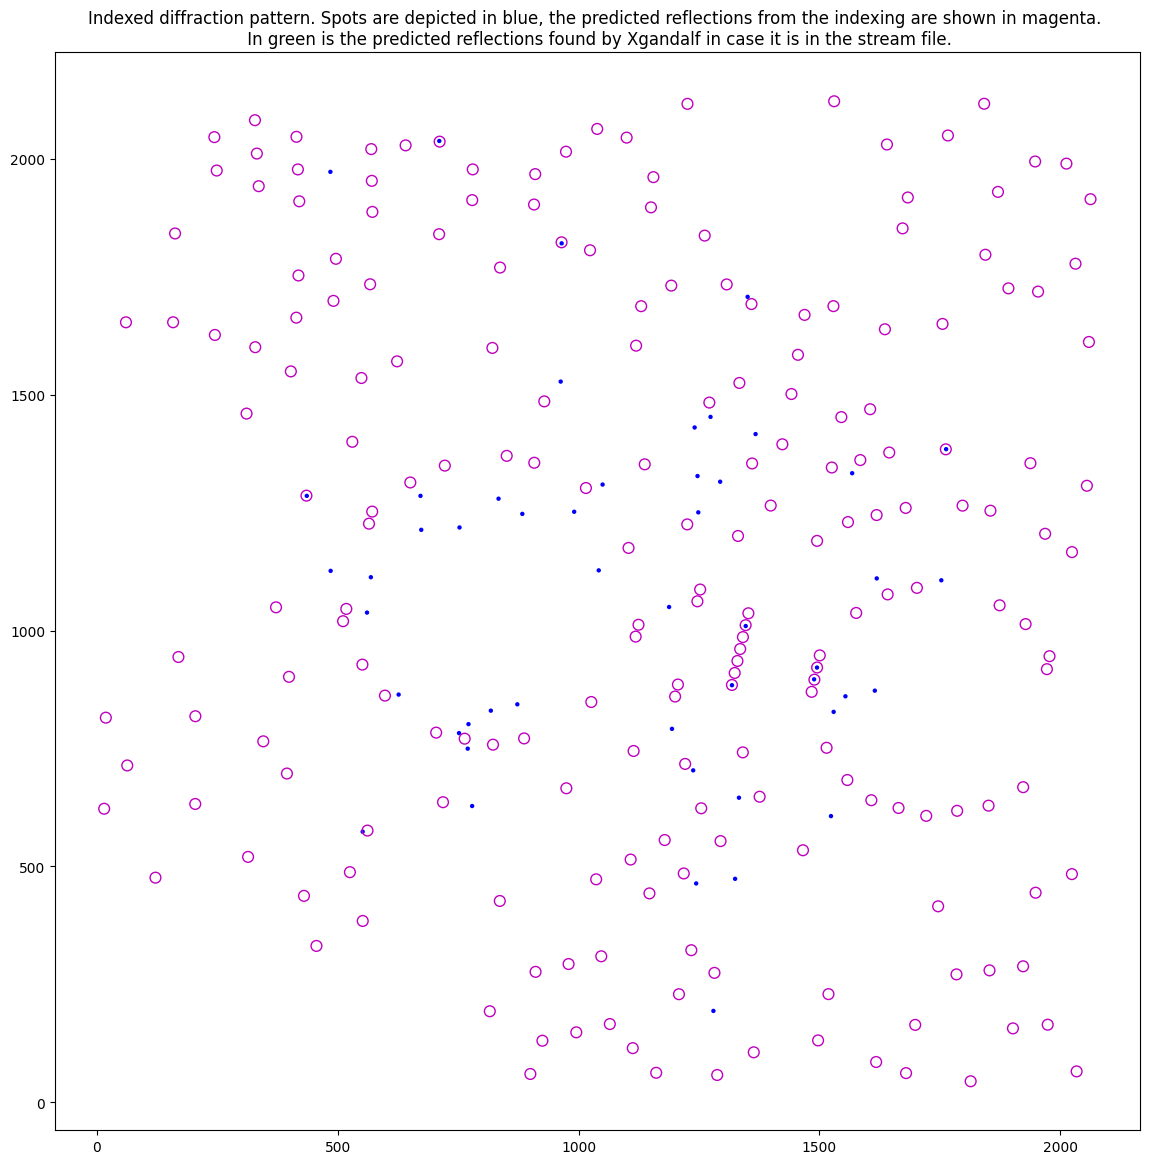

In [57]:
idx = random.randint(0, len(indices) - 1)
mds_idx = indices[idx]
cell_parameters = mds.instances[mds_idx]['initial_cell']
initial_cell = get_ideal_basis(cell_parameters)
print_solution(torch.tensor(bases[idx]), mds_idx, mds, initial_cell)